## One station models
LSTM_tensorflow_tutorial [link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [38]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math
from scipy import stats
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
%matplotlib inline

In [39]:
### Set fixed variables
input_path = 'data/PROCESSED/STATIONS_CLEAN'
path = 'data/PROCESSED/MODEL_OUTPUTS'

## sampling frequency
sample_freq = 60 #(time in minutes)
steps=int(sample_freq/5)
time_steps = int(60/sample_freq)
#60min - 12 steps
#30min - 6 steps
#15min - 3 steps
#5min - 1 step

MAX_EPOCHS = 20

#station
station = 'pampasSalasaca'

In [40]:
files_ids = {'guadalupe':'guadalupe_validation.csv',
         'banos':'banos_validation.csv',
         'aeropuerto': 'aeropuerto_validation.csv',
         'quisapincha':'quisapincha_validation.csv',
         'chiquiurco':'chiquiurco_validation.csv',
         'AJSucre':'AJSucre_validation.csv',
         'JAlvarez':'JAlvarez_validation.csv',
         'pfc-hgpt':'pfc-hgpt_validation.csv',
         'calamaca':'calamaca_validation.csv',
         'mulaCorral':'mulaCorral_validation.csv',
         'pampasSalasaca':'pampasSalasaca_validation.csv',
         'tasinteo':'tasinteo_validation.csv',
         'pisayambo':'pisayambo_validation.csv',
         'cunchibamba':'cunchibamba-hgpt_validation.csv'
         }

In [41]:
df = pd.read_csv(f'{input_path}/{station}_validation.csv')

In [42]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-04-05 17:25:00,8.596667,7.91,7.75,97.070,98.41,99.82,0.0,121.67,0.67,-0.351767,0.570228,-0.0,0.0,-0.0,0.0,-0.988362,-0.152123,0.997648,-0.068543
1,2013-04-05 17:30:00,8.484000,7.91,7.75,97.070,98.41,99.82,0.0,121.67,0.67,-0.351767,0.570228,-0.0,0.0,-0.0,0.0,-0.991445,-0.130526,0.997644,-0.068603
2,2013-04-05 17:35:00,8.440000,7.91,7.75,97.070,98.41,99.82,0.0,121.67,0.67,-0.351767,0.570228,-0.0,0.0,-0.0,0.0,-0.994056,-0.108867,0.997640,-0.068663
3,2013-04-05 17:40:00,8.292000,7.91,7.75,97.070,98.41,99.82,0.0,121.67,0.67,-0.351767,0.570228,-0.0,0.0,-0.0,0.0,-0.996195,-0.087156,0.997636,-0.068722
4,2013-04-05 17:45:00,8.384000,7.91,7.75,5.444,98.41,99.82,0.0,121.67,0.67,-0.351767,0.570228,-0.0,0.0,-0.0,0.0,-0.997859,-0.065403,0.997632,-0.068782


In [43]:
#### The data has already been cleaned, wind transformed to vector and added perodicity
### Check for NAN values and delete before running models
df.isna().sum()
df.isnull().values.any()

False

In [44]:
### Subsample to get data for every hour (starting from index 0, get 12 steps)
df = df[0::steps]

In [45]:
df.head()

,Date_Time,ATAvg,ATMax,ATMin,RHAvg,RHMin,RHMax,PAvg,WDAvg,WSAvg,WAvgx,WAvgy,WMaxx,WMaxy,WMinx,WMiny,Day_sin,Day_cos,Year_sin,Year_cos
0,2013-04-05 17:25:00,8.596667,7.91,7.75,97.070,98.41,99.82,0.0,121.670,0.67,-0.351767,0.570228,-0.0,0.0,-0.0,0.0,-0.988362,-0.152123,0.997648,-0.068543
12,2013-04-05 18:25:00,7.424000,6.90,6.78,56.068,99.85,99.88,0.0,123.945,0.46,-0.256863,0.381604,-0.0,0.0,-0.0,0.0,-0.994056,0.108867,0.997599,-0.069259
24,2013-04-05 19:25:00,6.774000,6.47,6.34,28.478,99.86,99.89,0.0,134.400,0.37,-0.258875,0.264355,-0.0,0.0,-0.0,0.0,-0.932008,0.362438,0.997549,-0.069974
36,2013-04-05 20:25:00,6.856000,6.27,6.16,20.194,99.87,99.90,0.0,141.930,0.39,-0.307031,0.240483,-0.0,-0.0,-0.0,0.0,-0.806445,0.591310,0.997498,-0.070689
48,2013-04-05 21:25:00,6.828000,6.17,6.06,80.384,99.87,99.90,0.0,135.970,0.38,-0.273211,0.264113,-0.0,0.0,-0.0,0.0,-0.625923,0.779884,0.997448,-0.071404


In [46]:
date_time = pd.to_datetime(df.pop('Date_Time'), format='%Y-%m-%d %H:%M:%S')

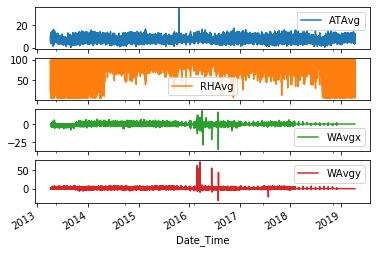

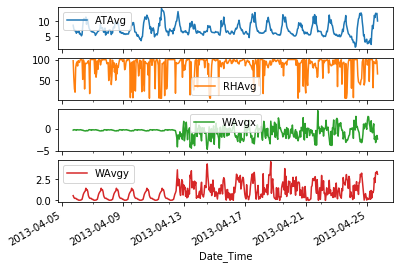

In [47]:
plot_cols = ['ATAvg', 'RHAvg', 'WAvgx','WAvgy']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [48]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ATAvg,52749.0,6.670131,2.199290,0.200000,5.190000,6.140000,7.800000,35.230000
ATMax,52749.0,6.776815,2.125330,0.280000,5.290000,6.215000,7.980000,37.630000
ATMin,52749.0,6.555358,2.007540,0.040000,5.170000,6.070000,7.670000,37.410000
RHAvg,52749.0,91.720344,13.654531,5.170000,88.340000,97.480000,99.890000,100.140000
RHMin,52749.0,93.107692,10.593992,5.140000,90.120000,97.720000,99.870000,100.130000
RHMax,52749.0,94.782449,9.529163,6.110000,93.030000,99.190000,99.900000,100.140000
PAvg,52749.0,0.009786,0.055547,0.000000,0.000000,0.000000,0.000000,3.000000
WDAvg,52749.0,156.378797,77.317647,0.000000,98.000000,137.500000,204.120000,360.000000
WSAvg,52749.0,1.297276,1.858144,0.000000,0.000000,0.758000,2.050000,73.910000
WAvgx,52749.0,-0.164012,0.956621,-35.466155,-0.489078,-0.000000,0.000000,18.443654


In [49]:
### Remove PAvg and WMaxx, WMiny, WDAvg and WSAvg
df = df[['ATAvg','ATMax','ATMin',
         'RHAvg','RHMin','RHMax',
         'WAvgx','WAvgy', 'WMinx', 'WMiny',
         'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos']]

In [50]:
### Split data into 70%, 20%, 10% split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [51]:
### Normalize the data  ### ROOM TO MAKE TESTS (this is just an average)
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

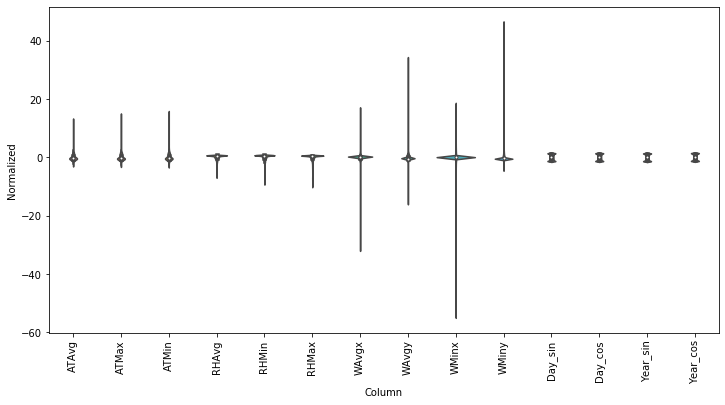

In [52]:
## Feature distributions
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [53]:
%run model_utils.ipynb

## MULTI-VARIATE + SINGLE STEP MODEL

- 24 hours prior --> predict 1 hour
- 24 hours prior --> predict 6 hours
- 48 hours prior --> predict 1 hours
- 48 hours prior --> predict 6 hours
- 48 hours prior --> predict 12 hours
- 48 hours prior --> predict 24 hours

## Windows

In [54]:
num_features = df.shape[1]

### 24 h + 1h

input_width = 24*time_steps
OUT_STEPS = 1*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 24 h + 6h

input_width = 24*time_steps
OUT_STEPS = 6*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 24 h + 24h

input_width = 24*time_steps
OUT_STEPS = 24*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 6h

input_width = 48*time_steps
OUT_STEPS = 6*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 12h

input_width = 48*time_steps
OUT_STEPS = 12*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 24h

input_width = 48*time_steps
OUT_STEPS = 24*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

### 48 h + 48h

input_width = 48*time_steps
OUT_STEPS = 48*time_steps
performance = single_models(num_features=num_features,
                                                 station=station,
                                                 path=path,
                                                 input_width=input_width, 
                                                 OUT_STEPS = OUT_STEPS)

# MULTI-VARIATE + MULTI-STEP MODEL

## Windows
- 24 hours prior --> predict 1-12 hour
- 24 hours prior --> predict 1-24 hours
- 48 hours prior --> predict 1-12 hours
- 48 hours prior --> predict 1-24 hours
- 48 hours prior --> predict 1-36 hours
- 48 hours prior --> predict 1-48 hours
- 72 hours prior --> predict 1-24 hours
- 72 hours prior --> predict 1-48 hours

### 24 h + 12h

In [55]:
num_features = df.shape[1]
vars_to_analize = ['ATAvg','RHAvg']
batch_size =32

329/329 [==============================] - 1s 4ms/step - loss: 0.2956 - mean_absolute_error: 0.2888


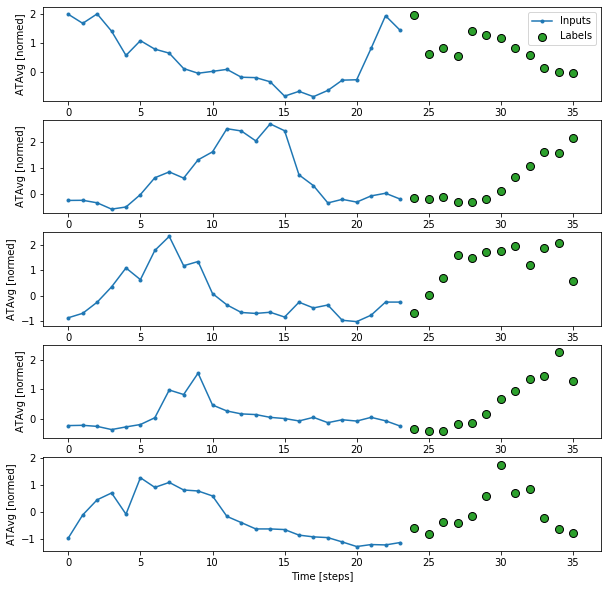

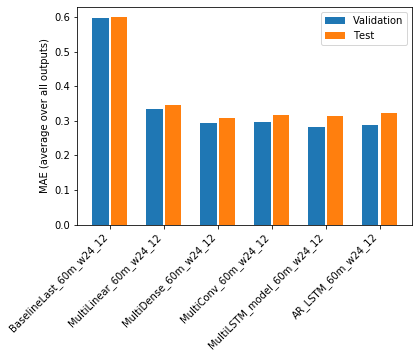

In [56]:
input_width = 24*time_steps
OUT_STEPS =12*time_steps
performance = multi_models(station, path, num_features,input_width, OUT_STEPS)

### 24 h + 24h

329/329 [==============================] - 2s 5ms/step - loss: 0.3122 - mean_absolute_error: 0.2893


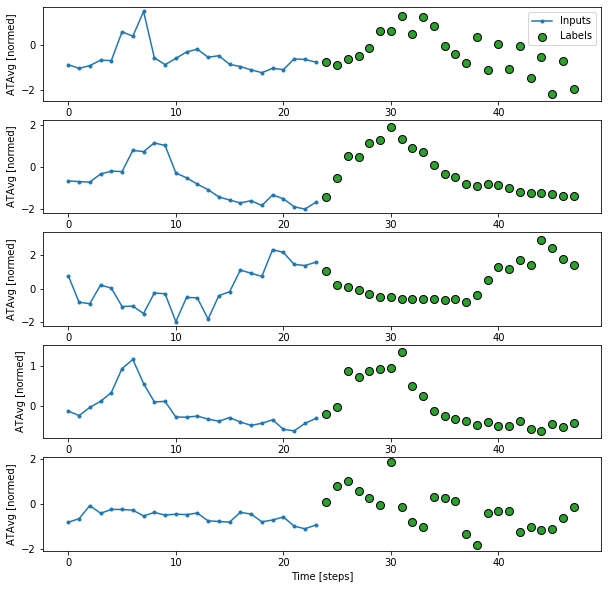

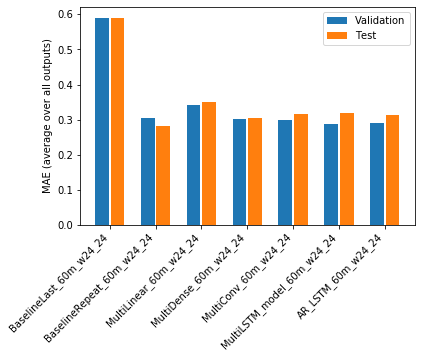

In [57]:
input_width = 24*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 12h

328/328 [==============================] - 2s 6ms/step - loss: 0.2962 - mean_absolute_error: 0.2947


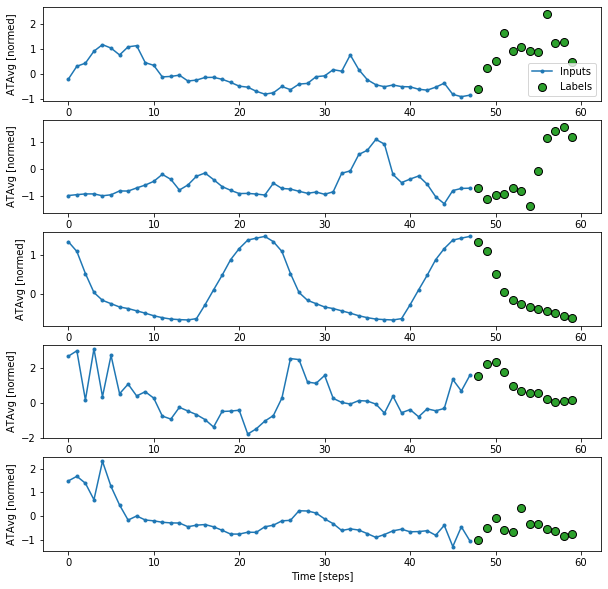

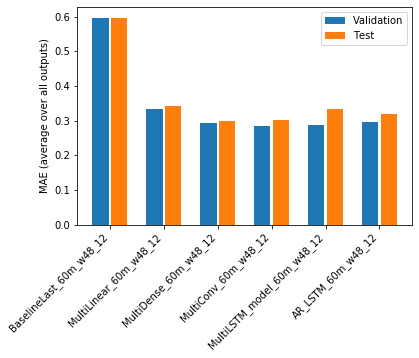

In [58]:
input_width = 48*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 24h

328/328 [==============================] - 3s 8ms/step - loss: 0.3170 - mean_absolute_error: 0.2972


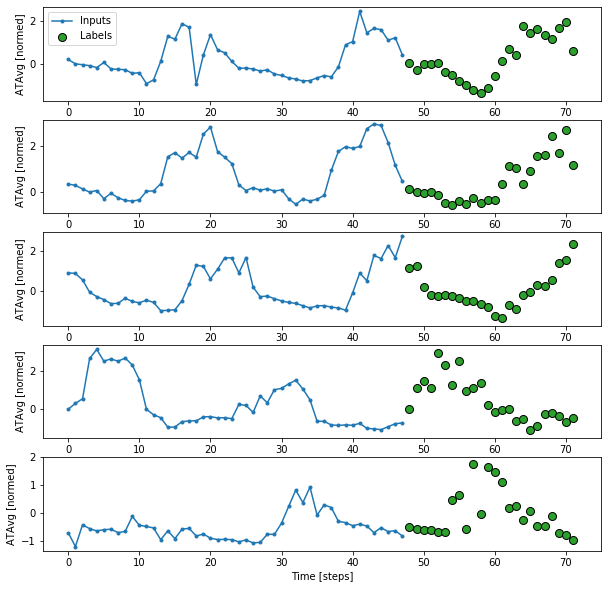

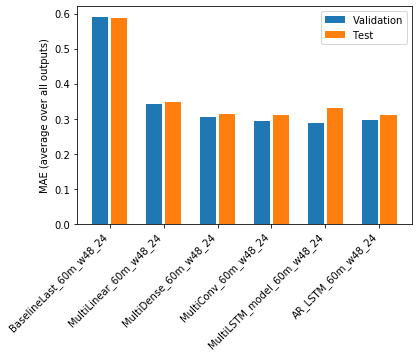

In [59]:
input_width = 48*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 48 h + 48h

327/327 [==============================] - 3s 8ms/step - loss: 0.3376 - mean_absolute_error: 0.3043


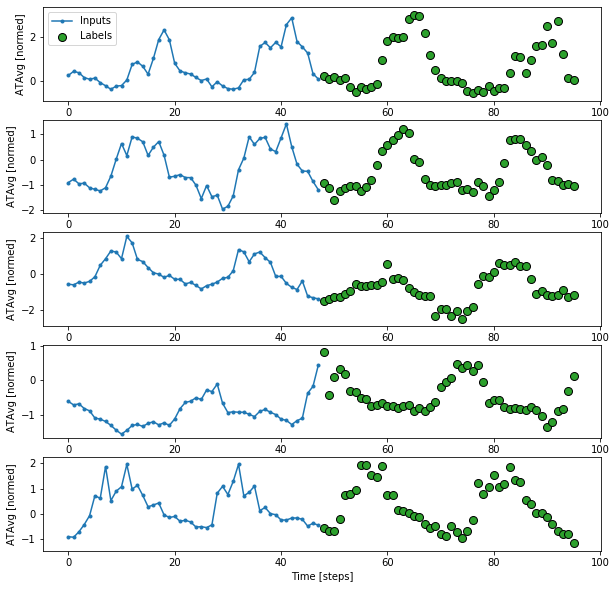

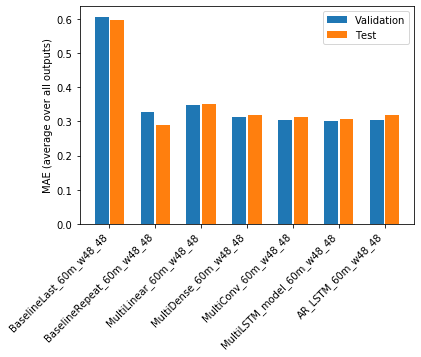

In [60]:
input_width = 48*time_steps
OUT_STEPS =48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)


### 72 h + 12h

328/328 [==============================] - 2s 7ms/step - loss: 0.2901 - mean_absolute_error: 0.2860


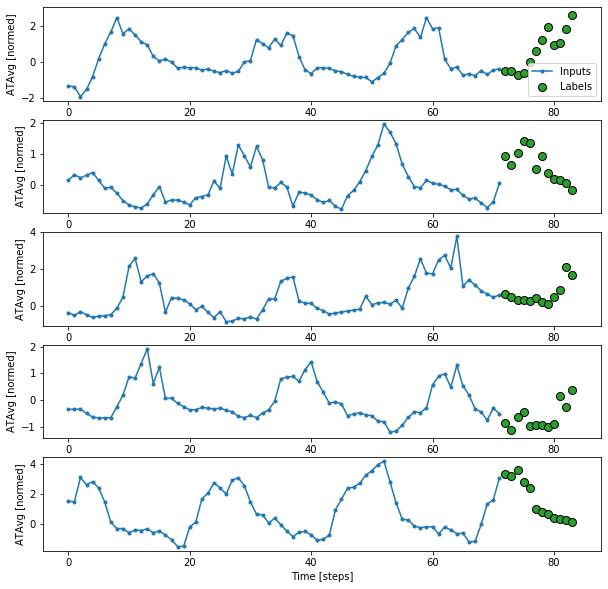

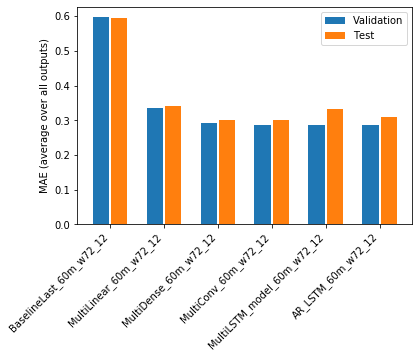

In [61]:
input_width = 72*time_steps
OUT_STEPS = 12*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 72 h + 24h

327/327 [==============================] - 3s 8ms/step - loss: 0.3216 - mean_absolute_error: 0.2964


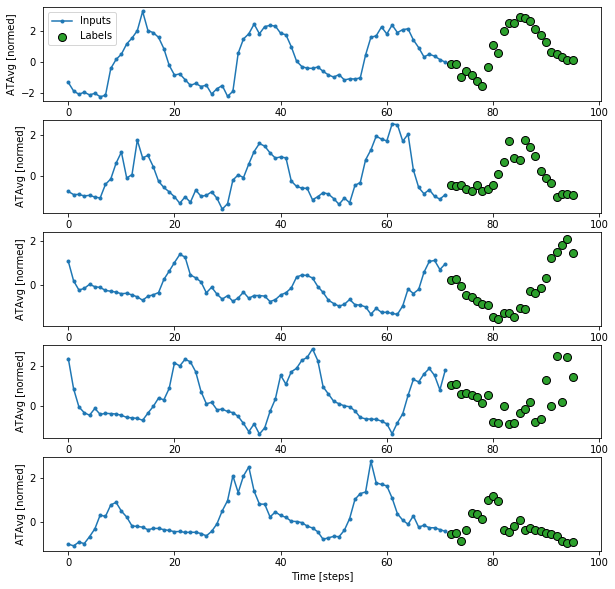

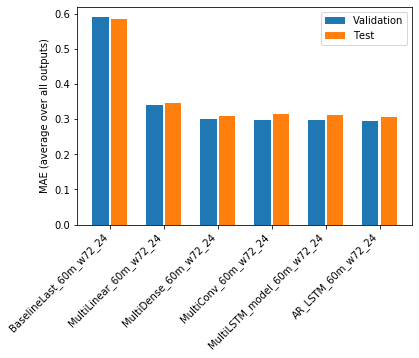

In [62]:
input_width = 72*time_steps
OUT_STEPS = 24*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)

### 72 h + 48h

326/326 [==============================] - 3s 9ms/step - loss: 0.3441 - mean_absolute_error: 0.3112


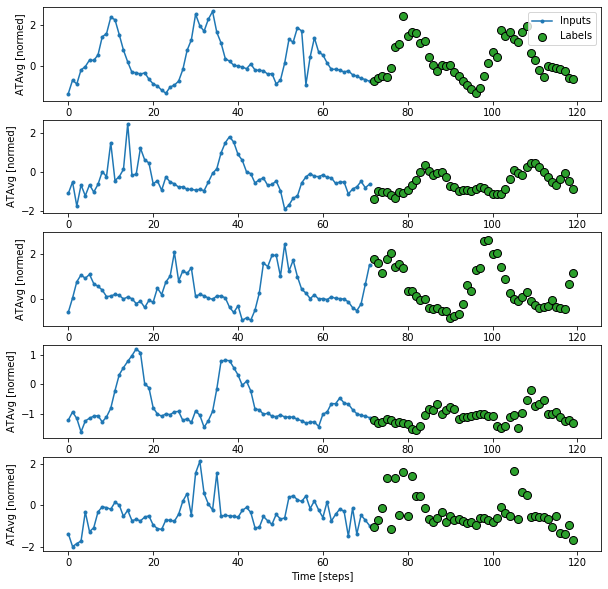

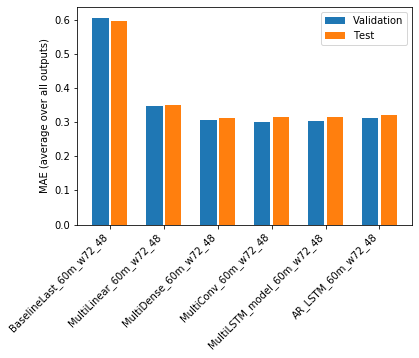

In [63]:
input_width = 72*time_steps
OUT_STEPS = 48*time_steps
performance = multi_models(station, path, num_features,input_width= input_width, OUT_STEPS=OUT_STEPS)